#CODICE DA NON TOCCARE


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import skewnorm

In [51]:
def campiona_skewnorm(rng: np.random.Generator, n: int, mu: float, sigma: float, a: float) -> np.ndarray:
    """
    Campiona *n* valori da una skew‑normal con media≈mu, sigma≈sigma e forma *a*.
    Un parametro *a* negativo produce una coda sinistra, cioè più valori al di
    sotto della media. La funzione corregge `loc` così che la media dei
    campioni corrisponda (in atteso) a `mu`, e garantisce che tutti i valori
    campionati siano strettamente positivi.
    """
    if n == 0:
        return np.empty(0)

    # Calcola loc correttivo per avere media ≈ mu
    delta = a / math.sqrt(1.0 + a * a)
    loc = mu - sigma * delta * math.sqrt(2.0 / math.pi)

    # Campionamento iniziale
    samples = skewnorm.rvs(a, loc=loc, scale=sigma, size=n, random_state=rng)

    # Rejection sampling: risampiona finché non sono tutti > 0
    neg = samples <= 0
    while np.any(neg):
        samples[neg] = skewnorm.rvs(
            a,
            loc=loc,
            scale=sigma,
            size=neg.sum(),
            random_state=rng
        )
        neg = samples <= 0

    return samples

In [3]:
def prime_due_cifre_prod(val: float) -> int:
    decimali = f"{abs(val):.5f}".split(".")[1]
    d1 = int(decimali[0])
    d2 = int(decimali[1]) if len(decimali) > 1 else 0
    return d1 * d2

In [4]:
def soglia_metodo_A(ribassi: np.ndarray) -> float:
    n = ribassi.size
    k = math.ceil(0.10 * n)
    sorted_r = np.sort(ribassi)
    low_lim, high_lim = sorted_r[k - 1], sorted_r[-k]
    core = ribassi[(ribassi > low_lim) & (ribassi < high_lim)]
    media_core = core.mean()
    sopra = core[core > media_core]
    scarto_med = (sopra - media_core).mean() if sopra.size else 0.0
    perc = prime_due_cifre_prod(core.sum()) / 100.0
    return media_core + scarto_med * (1 - perc)

In [5]:
def soglia_metodo_B(ribassi: np.ndarray) -> float:
    n = ribassi.size
    k = math.ceil(0.10 * n)
    sorted_r = np.sort(ribassi)
    low_lim, high_lim = sorted_r[k - 1], sorted_r[-k]
    core = ribassi[(ribassi > low_lim) & (ribassi < high_lim)]
    media_core = core.mean()
    sopra = core[core > media_core]
    scarto_med = (sopra - media_core).mean() if sopra.size else 0.0
    rapporto = scarto_med / media_core if media_core else 0.0
    return media_core * 1.20 if rapporto <= 0 else media_core + scarto_med


In [6]:
def calcola_soglia(ribassi: np.ndarray, metodo: str) -> float:
    m = metodo.upper()
    if m == "A":
        return soglia_metodo_A(ribassi)
    elif m == "B":
        return soglia_metodo_B(ribassi)
    else:
        raise ValueError("Metodo non valido. Usa 'A' o 'B'.")

In [23]:
def esito_gara(ribassi: np.ndarray, bid: float, metodo: str) -> float:
    soglia = calcola_soglia(ribassi, metodo)
    valide = ribassi[ribassi < soglia]
    if not valide.size:
        return 0.0
    max_valida = valide.max()
    if abs(bid - max_valida) < 1e-12:
        ties = (abs(valide - max_valida) < 1e-12).sum()
        return 1.0 / ties
    return 0.0

In [24]:
def simula_gara(bid: float, rng: np.random.Generator, parametri: dict, metodo: str) -> tuple[float, int]:
    wins = 0.0
    sotto_soglia5 = 0

    for _ in range(parametri["N_SIM"]):
        presenze = rng.random(parametri["PARTECIPANTI_MAX"] - 1) < parametri["PROB_PRESENTE"]
        n_altri = presenze.sum()

        altri = campiona_skewnorm(
            rng,
            n_altri,
            parametri["MEDIA"],
            parametri["SIGMA"],
            parametri["SKEW_A"],
        )

        ribassi = np.append(altri, bid)
        n_presenti = ribassi.size

        if n_presenti < 5:
            vincente = ribassi.max()
            sotto_soglia5 += 1
            if abs(bid - vincente) < 1e-12:
                ties = (abs(ribassi - vincente) < 1e-12).sum()
                wins += 1.0 / ties
        else:
            wins += esito_gara(ribassi, bid, metodo)

    return wins / parametri["N_SIM"], sotto_soglia5


In [9]:
def simulazione_once(parametri: dict) -> None:
    rng = np.random.default_rng(seed=np.random.randint(1_000_000))
    metodo = parametri["METODO_SOGLIA"].upper()
    my_bids = np.arange(parametri["LIMITE_INFERIORE"],
                        parametri["LIMITE_SUPERIORE"], 0.01)
    n_trials = parametri["N_SIM"]
    max_other = parametri["PARTECIPANTI_MAX"] - 1

    # 1) Simulo presenze e ribassi degli altri una sola volta
    presenze = rng.random((n_trials, max_other)) < parametri["PROB_PRESENTE"]

    a = parametri["SKEW_A"]
    mu, sigma = parametri["MEDIA"], parametri["SIGMA"]
    delta = a / math.sqrt(1 + a * a)
    loc = mu - sigma * delta * math.sqrt(2.0 / math.pi)

    altri_raw = skewnorm.rvs(a,
                             loc=loc,
                             scale=sigma,
                             size=(n_trials, max_other),
                             random_state=rng)

    competitor_vals = np.where(presenze, altri_raw, np.nan)
    n_presenti = presenze.sum(axis=1) + 1
    below5 = n_presenti < 5
    pct_below5 = np.mean(below5) * 100

    # 2) Per ogni nostro ribasso, calcolo win rate
    win_rates = np.zeros_like(my_bids)
    for idx, bid in enumerate(my_bids):
        wins = 0.0
        for i in range(n_trials):
            comp = competitor_vals[i][~np.isnan(competitor_vals[i])]
            ribassi = np.concatenate([comp, [bid]])
            if below5[i]:
                max_bid = ribassi.max()
                if abs(bid - max_bid) < 1e-12:
                    ties = np.sum(np.isclose(ribassi, max_bid))
                    wins += 1.0 / ties
            else:
                soglia = calcola_soglia(ribassi, metodo)
                valid = ribassi[ribassi < soglia]
                if valid.size:
                    max_val = valid.max()
                    if abs(bid - max_val) < 1e-12:
                        ties = np.sum(np.isclose(valid, max_val))
                        wins += 1.0 / ties
        win_rates[idx] = wins / n_trials

    # 3) Risultati
    df = pd.DataFrame({
        "Ribasso (%)": my_bids,
        "Probabilità di aggiudicazione": win_rates
    })

    print(df.head(10))
    print(f"\nMetodo usato: {metodo}")
    print(f"Percentuale aste con <5 partecipanti: {pct_below5:.2f}%")
    best = df.loc[df["Probabilità di aggiudicazione"].idxmax()]
    print(f"\nRibasso migliore: {best['Ribasso (%)']:.2f}%  →  Prob = {best['Probabilità di aggiudicazione']:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(df["Ribasso (%)"], df["Probabilità di aggiudicazione"])
    plt.xlabel("Ribasso proposto (%)")
    plt.ylabel("Probabilità di aggiudicazione")
    plt.title(f"Probabilità di vincere vs Ribasso proposto (metodo {metodo})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# PARAMENTRI DA INSERIRE

   Ribasso (%)  Probabilità di aggiudicazione
0         1.50                          0.001
1         1.51                          0.001
2         1.52                          0.001
3         1.53                          0.001
4         1.54                          0.001
5         1.55                          0.001
6         1.56                          0.001
7         1.57                          0.001
8         1.58                          0.001
9         1.59                          0.001

Metodo usato: A
Percentuale aste con <5 partecipanti: 34.20%

Ribasso migliore: 27.82%  →  Prob = 0.3420


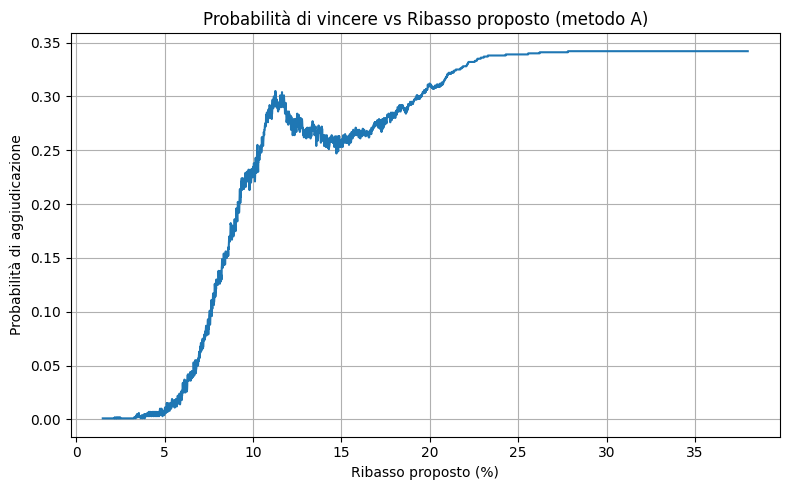

In [27]:
parametri = {
    "MEDIA": 11.75,   # campo evidenziato in verde nel file Excel
    "SIGMA": 6.24,    # campo evidenziato in verde nel file Excel

    "SKEW_A": 3,      # asimmetria (negativo ⇒ piu coda sinistra, positivo ⇒ piu coda destra[ribassi piu elevati])

    "PARTECIPANTI_MAX": 5,   # campo evidenziato in verde nel file Excel
    "PROB_PRESENTE": 0.9,    # campo evidenziato in verde nel file Excel

    "N_SIM": 1000, #Numero di gare simulate

    "LIMITE_INFERIORE": 1.5, # limite inferiore per i nostri ribassi
    "LIMITE_SUPERIORE": 38,  # limite superiore per i nostri ribassi

    "METODO_SOGLIA": "A",   # <–– qui si sceglie il metodo di calcolo della soglia "A" o "B"
}

# Esecuzione
simulazione_once(parametri)

### VERIFICA CURVA UTILIZZATA


In [63]:
rng = np.random.default_rng(0)  # per riproducibilità
mu, sigma = 10.0, 6.4
sample_size = 2000

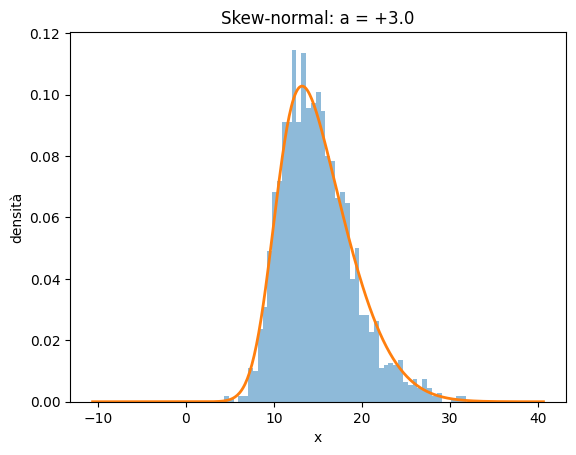

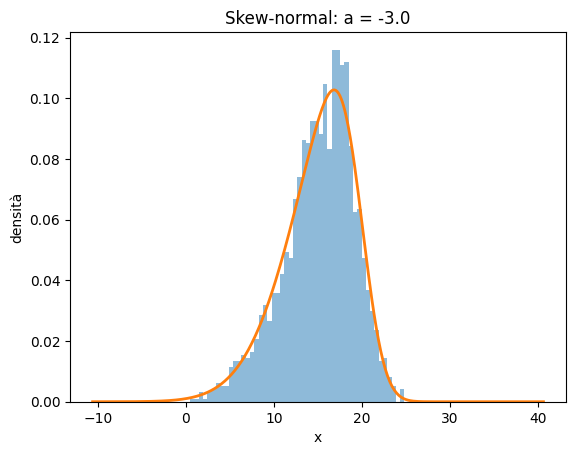

In [65]:
for a in [3.0, -3.0]:  # coda destra e coda sinistra
    samples = campiona_skewnorm(rng, sample_size, mu, sigma, a)

    # PDF teorica per confronto
    delta = a / math.sqrt(1.0 + a * a)
    loc = mu - sigma * delta * math.sqrt(2.0 / math.pi)
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 400)
    pdf = skewnorm.pdf(x, a, loc=loc, scale=sigma)

    plt.figure()
    plt.hist(samples, bins=50, density=True, alpha=0.5)
    plt.plot(x, pdf, linewidth=2)
    plt.title(f"Skew-normal: a = {a:+}")
    plt.xlabel("x")
    plt.ylabel("densità")
    plt.show()